In [98]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
!pip install torchaudio
import torch
import torchaudio
import librosa

In [100]:
data_path = '/content/drive/MyDrive/(남성)흐흐흐흐.wav'
sample_librosa, sr_librosa = librosa.load(data_path, sr = 11025)
sample_taudio, sr_taudio = torchaudio.load(data_path)

print('sample rate from librosa load : ',sr_librosa)
print('sample rate from torchaudio load : ',sr_taudio)

sample rate from librosa load :  11025
sample rate from torchaudio load :  11025


Text(0.5, 1.0, 'torchaudio sample')

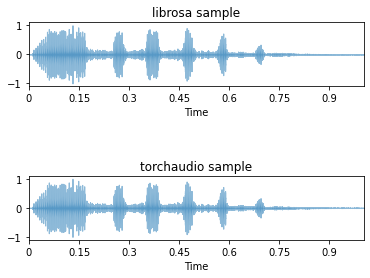

In [101]:
import matplotlib.pyplot as plt
from librosa import display
import numpy as np

plt.subplot(3,1,1)
display.waveplot(sample_librosa, alpha = 0.5)
plt.title("librosa sample")

plt.subplot(3,1,3)
display.waveplot(sample_taudio.squeeze().numpy(), alpha = 0.5)
plt.title("torchaudio sample")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


Text(0.5, 1.0, 'spectrogram with pytorch')

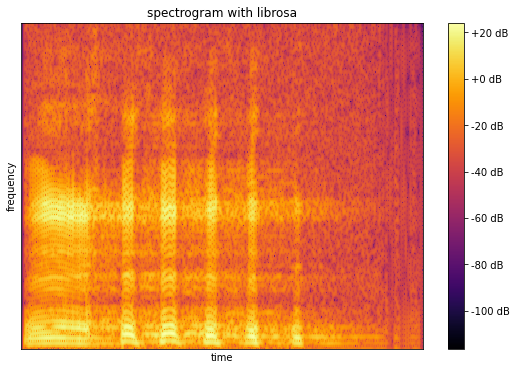

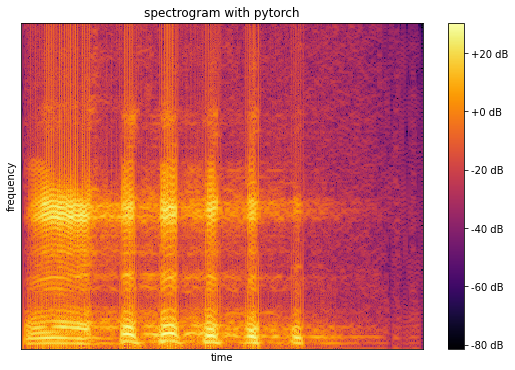

In [102]:
### STFT with librosa ###
## set hop length and window length with sample rate
hop_length = int(sr_librosa * 0.001)
win_length = int(sr_librosa * 0.025)
## calculate spectrogram
spec_librosa = librosa.stft(sample_librosa, n_fft = 512, hop_length = hop_length, win_length = win_length)

## spec_librosa is complex, make it absolute magnitude values, it returns freq * time
mag_spec_lib = np.abs(spec_librosa)

## change it into decibel
dB_spec_lib = 20 * np.log10(mag_spec_lib)

## plot spectrogram
plt.figure(figsize = (9, 6))
librosa.display.specshow(dB_spec_lib, sr = sr_librosa, hop_length = hop_length, cmap = 'inferno')
plt.xlabel("time")
plt.ylabel("frequency")
plt.colorbar(format = "%+2.0f dB")
plt.title("spectrogram with librosa")

###################################################################################################################
####################################### Compare with librosa and pytorch ##########################################
###################################################################################################################


### STFT with pytorch ###
## set hop length and window length with sample rate
hop_length = int(sr_taudio * 0.001)
win_length = int(sr_taudio * 0.025)
## calculate spectrogram
spec_torch = torch.stft(sample_taudio, n_fft = 512, hop_length = hop_length, win_length = win_length, return_complex = True)

## spec_torch is complex
mag_spec_torch = torch.abs(spec_torch)

## change it into decibel
dB_spec_torch = 20 * torch.log10(mag_spec_torch)
## plot spectrogram
plt.figure(figsize = (9, 6))
librosa.display.specshow(dB_spec_torch.squeeze().numpy(), sr = sr_taudio, hop_length = hop_length, cmap = 'inferno')
plt.xlabel("time")
plt.ylabel("frequency")
plt.colorbar(format = "%+2.0f dB")
plt.title("spectrogram with pytorch")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'melspectrogram with pytorch')

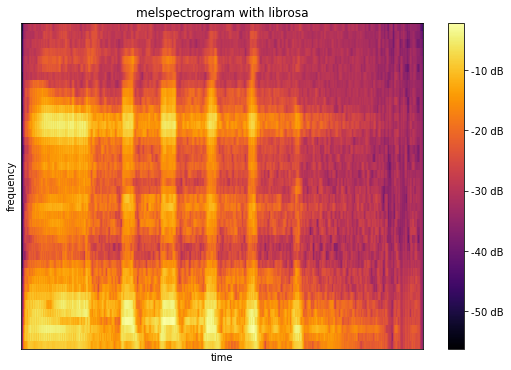

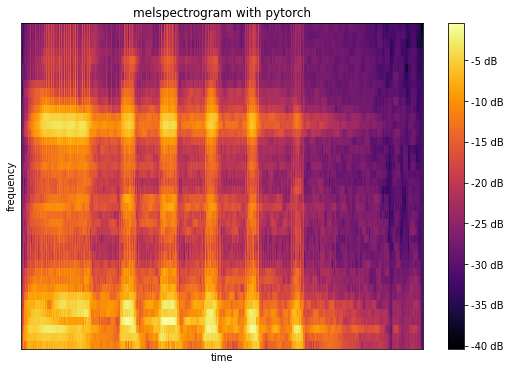

In [103]:
#### Mel filterbank ####
fb_lib = librosa.filters.mel(sr = sr_librosa, n_fft = 512, n_mels = 40)
fb_torch = torchaudio.functional.create_fb_matrix(sample_rate = sr_librosa, n_freqs = 257,
                                                  n_mels = 40, f_min = 0.0, f_max = sr_taudio/2.0,
                                                  norm = 'slaney', mel_scale = 'slaney')

#### Multiply Mel filterbank on each spectrogram ####
mel_spec_lib = np.matmul(fb_lib, mag_spec_lib)

#dB_mel_lib = librosa.power_to_db(mel_spec_lib)
dB_mel_lib = 10*np.log10(mel_spec_lib)

mel_spec_torch = torch.matmul(mag_spec_torch.transpose(1,2), fb_torch).transpose(1,2)

#dB_mel_torch = torchaudio.functional.amplitude_to_DB(mel_spec_torch, 10.0, 1e-10, 1.0, 80.0)
dB_mel_torch = 10*torch.log10(mel_spec_torch)

## plot mel spectrogram
plt.figure(figsize = (9, 6))
librosa.display.specshow(dB_mel_lib, sr = sr_librosa, hop_length = hop_length, cmap = 'inferno')
plt.xlabel("time")
plt.ylabel("frequency")
plt.colorbar(format = "%+2.0f dB")
plt.title("melspectrogram with librosa")

## plot mel spectrogram
plt.figure(figsize = (9, 6))
librosa.display.specshow(dB_mel_torch.squeeze().numpy(), sr = sr_taudio, hop_length = hop_length, cmap = 'inferno')
plt.xlabel("time")
plt.ylabel("frequency")
plt.colorbar(format = "%+2.0f dB")
plt.title("melspectrogram with pytorch")

Text(0.5, 1.0, 'MFCCs with pytorch')

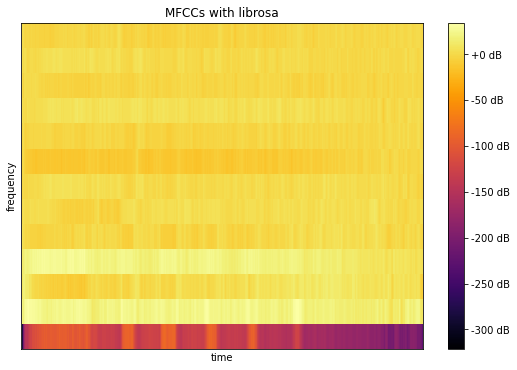

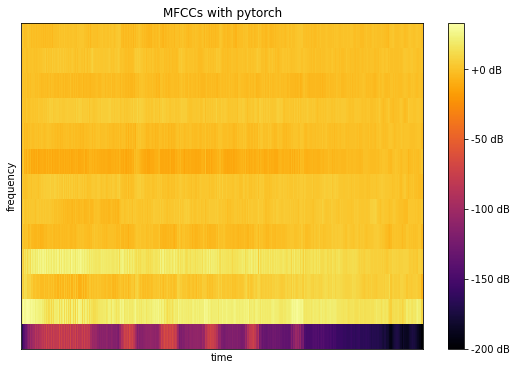

In [104]:
##### Let's Calculate MFCCs!! ######
MFCC_lib = librosa.feature.mfcc(S = dB_mel_lib, sr = sr_librosa, n_mfcc = 13)

dct_torch = torchaudio.functional.create_dct(13, 40, norm = 'ortho')
MFCC_torch = torch.matmul(dB_mel_torch.transpose(1, 2), dct_torch).transpose(1, 2)

## plot MFCC
plt.figure(figsize = (9, 6))
librosa.display.specshow(MFCC_lib, sr = sr_librosa, hop_length = hop_length, cmap = 'inferno')
plt.xlabel("time")
plt.ylabel("frequency")
plt.colorbar(format = "%+2.0f dB")
plt.title("MFCCs with librosa")

## plot MFCC
plt.figure(figsize = (9, 6))
librosa.display.specshow(MFCC_torch.squeeze().numpy(), sr = sr_taudio, hop_length = hop_length, cmap = 'inferno')
plt.xlabel("time")
plt.ylabel("frequency")
plt.colorbar(format = "%+2.0f dB")
plt.title("MFCCs with pytorch")

Text(0.5, 1.0, 'MFCCs with pytorch')

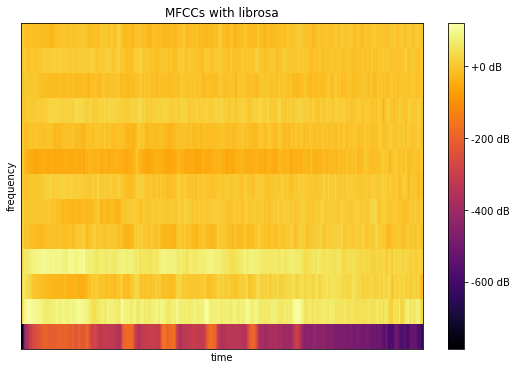

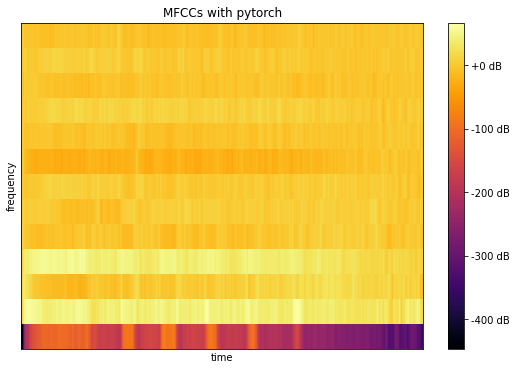

In [108]:
#### get features directly from audio samples ####
MFCC_lib2 = librosa.feature.mfcc(y = sample_librosa, sr = sr_librosa, n_mfcc = 13, n_fft = 512,
                                 hop_length = hop_length, win_length = win_length)

#### create class instance for mfcc torchaudio ####
args = {'n_mels' : 40, 'n_fft' : 512, 'win_length' : win_length, 'hop_length' : hop_length,
        'f_max' : sr_taudio / 2, 'mel_scale' : 'slaney', 'norm' : 'slaney'}
mfcc_calc = torchaudio.transforms.MFCC(sample_rate = sr_taudio, n_mfcc = 13, melkwargs = args)

MFCC_torch2 = mfcc_calc(sample_taudio)

## plot MFCC
plt.figure(figsize = (9, 6))
librosa.display.specshow(MFCC_lib2, sr = sr_librosa, hop_length = hop_length, cmap = 'inferno')
plt.xlabel("time")
plt.ylabel("frequency")
plt.colorbar(format = "%+2.0f dB")
plt.title("MFCCs with librosa")

## plot MFCC
plt.figure(figsize = (9, 6))
librosa.display.specshow(MFCC_torch2.squeeze().numpy(), sr = sr_taudio, hop_length = hop_length, cmap = 'inferno')
plt.xlabel("time")
plt.ylabel("frequency")
plt.colorbar(format = "%+2.0f dB")
plt.title("MFCCs with pytorch")